# Introduction to Python  

### Geographical and Spatial Analysis

Installing packages and extensions

In [21]:
## Installing jupyterlab extensions
!jupyter labextension install jupyterlab-plotly
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension enable --py plotlywidget --sys-prefix

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
An error occurred.
ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
See the log file for details:  /var/folders/w_/q22k4_314ld80dxxyxtzx5v00000gn/T/jupyterlab-debug-00decqg7.log
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Traceback (most recent call last):
  File "/Users/Clara/anaconda3/bin/jupyter-nbextension", line 11, in <module>
    sys.exit(main())
             ^^^^^^
  File "/Users/Clara/anaconda3/lib/python3.11/site-packages/jupyter_core/application.py", lin

In [22]:
!pip install -U plotly plotly-geo geopandas shapely pyshp html5lib nominatim geopy pydotplus python-twitter ipywidgets descartes chart_studio

### Some tools to present:  
+ [Geopandas](https://geopandas.org/en/stable/index.html)  
+ [Leaflet](https://leafletjs.com/index.html)  
+ [Folium](https://python-visualization.github.io/folium/)  
+ [Open Street Maps](https://www.openstreetmap.org/)  

### Concepts:  
+ [GeoJson](https://geojson.org/)  
+ [Shapefiles](https://en.wikipedia.org/wiki/Shapefile)  

### Example Data Sources (Austria)  
+ [Bezirke Data](https://www.data.gv.at/katalog/dataset/stadt-wien_bezirksgrenzenwien)  
+ [Vienna GIS](https://www.wien.gv.at/viennagis/datenquellen/)  

Importing packages

In [23]:
import re
import sys
import os
import json
import time
import codecs
from datetime import datetime
from datetime import timedelta
from itertools import chain
from itertools import cycle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import Levenshtein
#import networkx as nx
import twitter
import nltk

import requests
import urllib
from urllib.request import urlopen
import webbrowser
from bs4 import BeautifulSoup

#import pydotplus #Install http://www.graphviz.org/ & Instal https://pypi.python.org/pypi/pydotplus

from IPython.display import Image, HTML, IFrame, FileLink, FileLinks #needed to render in notebook
from IPython.display import display
import ipywidgets as widgets

%matplotlib inline

ModuleNotFoundError: No module named 'Levenshtein'

Set default figure size for this notebook

In [ ]:
plt.rcParams['figure.figsize'] = (16.0, 12.8)
#plt.switch_backend('Agg')


My Maps
## Using Geopy geolocators

[Geopy](https://pypi.python.org/pypi/geopy)  
[Geopy Geocoders](https://geopy.readthedocs.io/en/stable/#module-geopy.geocoders)

In [ ]:
import geopy.geocoders as gg

geolocator = gg.Nominatim(user_agent="test_application") #https://operations.osmfoundation.org/policies/nominatim/

#### To geolocate a query to an address and coordinates:

In [ ]:
address = "Universitätsring 1, 1010 Wien"
location = geolocator.geocode(address)
print(location.address)

In [ ]:
address = "Stadtpark Wien"
location = geolocator.geocode(address)
print(location.address)

In [ ]:
print((location.latitude, location.longitude))

In [ ]:
print(json.dumps(location.raw, indent=4, sort_keys=True))

#### To find an address with coordinates:

In [ ]:
addresses = geolocator.reverse((48.4,16.1))
for address in addresses:
    print(address)

#### More precise coordinates

In [ ]:
coordinates = (49.313237, 16.360047)
location = geolocator.reverse(coordinates)
print(location.address)

In [ ]:
print((location.latitude, location.longitude))

In [ ]:
print(json.dumps(location.raw, indent=4, sort_keys=True))

### Showing coordinates on embedded map using display

[Google maps](https://developers.google.com/maps/documentation/staticmaps/)  
[Google maps parameters](http://stackoverflow.com/questions/2660201/what-parameters-should-i-use-in-a-google-maps-url-to-go-to-a-lat-lon/9919251#9919251)

m – normal map  
k – satellite  
h – hybrid  
p – terrain

In [ ]:
from IPython.display import display

In [ ]:
def gmap(address,lat,lon,zoom=15,tmap='m'):
    # Google Maps URL template for an iframe
    base_url = 'http://maps.google.com/maps'
    gmap_url = base_url + f'?q={address}&loc:{lat}+{lon}&z={zoom}&t={tmap}&output=embed'
    display(IFrame(gmap_url, '800px', '600px'))
    
gmap(location.address, location.latitude, location.longitude, 17, 'k')


My Maps
## Using [Geopandas](https://geopandas.org/index.html)

Pandas Dataframes can be belong to these datatypes:  

<table border="1" class="colwidths-given table table-condensed docutils">
<caption>Pandas <code class="code">
dtype</code>
 mapping</caption>
<colgroup>
<col width="13%"/>
<col width="13%"/>
<col width="38%"/>
<col width="38%"/>
</colgroup>
<thead valign="bottom">
<tr><th class="head">Pandas dtype</th>
<th class="head">Python type</th>
<th class="head">NumPy type</th>
<th class="head">Usage</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>object</td>
<td>str or mixed</td>
<td>string_, unicode_, mixed types</td>
<td>Text or mixed numeric and non-numeric values</td>
</tr>
<tr><td>int64</td>
<td>int</td>
<td>int_, int8, int16, int32, int64, uint8, uint16, uint32, uint64</td>
<td>Integer numbers</td>
</tr>
<tr><td>float64</td>
<td>float</td>
<td>float_, float16, float32, float64</td>
<td>Floating point numbers</td>
</tr>
<tr><td>bool</td>
<td>bool</td>
<td>bool_</td>
<td>True/False values</td>
</tr>
<tr><td>datetime64</td>
<td><span class="caps">NA</span></td>
<td>datetime64[ns]</td>
<td>Date and time values</td>
</tr>
<tr><td>timedelta[ns]</td>
<td><span class="caps">NA</span></td>
<td><span class="caps">NA</span></td>
<td>Differences between two datetimes</td>
</tr>
<tr><td>category</td>
<td><span class="caps">NA</span></td>
<td><span class="caps">NA</span></td>
<td>Finite list of text values</td>
</tr>
</tbody>
</table>


GeoPandas, as the name suggests, extends popular data science library pandas by adding support for geospatial data.    

The core data structure in GeoPandas is geopandas.GeoDataFrame, a subclass of pandas.DataFrame able to store geometry columns and perform spatial operations. Geometries are handled by geopandas.GeoSeries, a subclass of pandas.Series. Therefore, your GeoDataFrame is a combination of Series with your data (numerical, boolean, text etc.) and GeoSeries with geometries (points, polygons etc.).  

![](https://geopandas.org/_images/dataframe.svg)

In [29]:
import geopandas as gpd
from geopandas.tools import geocode
from shapely.geometry import LineString, MultiPolygon

In [30]:
gdf = gpd.read_file(gpd.datasets.get_path("nybb"))

gdf

/var/folders/w_/q22k4_314ld80dxxyxtzx5v00000gn/T/ipykernel_79964/2308636323.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'nybb' data from the geodatasets package.

from geodatasets import get_path
path_to_file = get_path('nybb')

  gdf = gpd.read_file(gpd.datasets.get_path("nybb"))


,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


#### Measuring area

In [31]:
gdf = gdf.set_index("BoroName")

In [32]:
gdf["area"] = gdf.area
gdf["area"]

BoroName
Staten Island    1.623822e+09
Queens           3.045214e+09
Brooklyn         1.937478e+09
Manhattan        6.364712e+08
Bronx            1.186926e+09
Name: area, dtype: float64

#### Getting polygon boundary and centroid

In [33]:
gdf['boundary'] = gdf.boundary
gdf['boundary']

BoroName
Staten Island    MULTILINESTRING ((970217.022 145643.332, 97022...
Queens           MULTILINESTRING ((1029606.077 156073.814, 1029...
Brooklyn         MULTILINESTRING ((1021176.479 151374.797, 1021...
Manhattan        MULTILINESTRING ((981219.056 188655.316, 98094...
Bronx            MULTILINESTRING ((1012821.806 229228.265, 1012...
Name: boundary, dtype: geometry

In [34]:
gdf['centroid'] = gdf.centroid
gdf['centroid']

BoroName
Staten Island     POINT (941639.450 150931.991)
Queens           POINT (1034578.078 197116.604)
Brooklyn          POINT (998769.115 174169.761)
Manhattan         POINT (993336.965 222451.437)
Bronx            POINT (1021174.790 249937.980)
Name: centroid, dtype: geometry

#### Measuring distance

In [35]:
first_point = gdf['centroid'].iloc[0]
gdf['distance'] = gdf['centroid'].distance(first_point)
gdf['distance']

BoroName
Staten Island         0.000000
Queens           103781.535276
Brooklyn          61674.893421
Manhattan         88247.742789
Bronx            126996.283623
Name: distance, dtype: float64

#### Making maps

<Axes: >

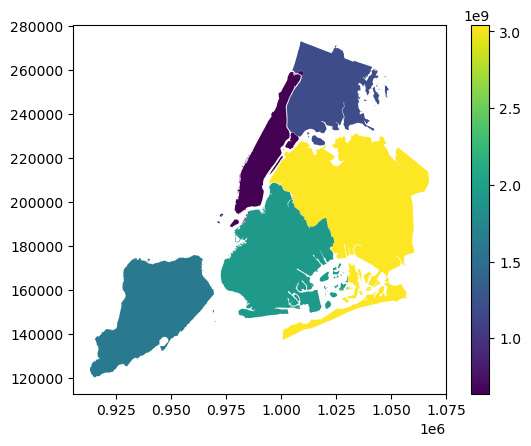

In [36]:
gdf.plot("area", legend=True)

<Axes: >

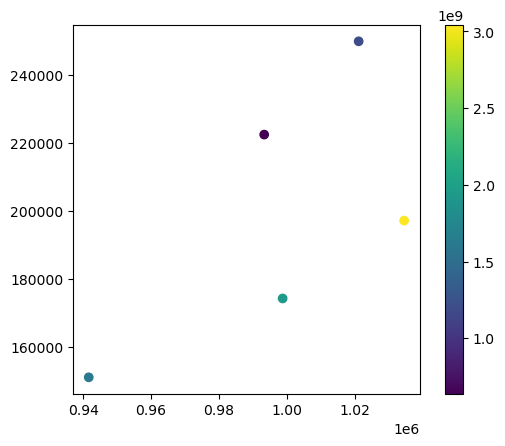

In [37]:
gdf = gdf.set_geometry("centroid")
gdf.plot("area", legend=True)

<Axes: >

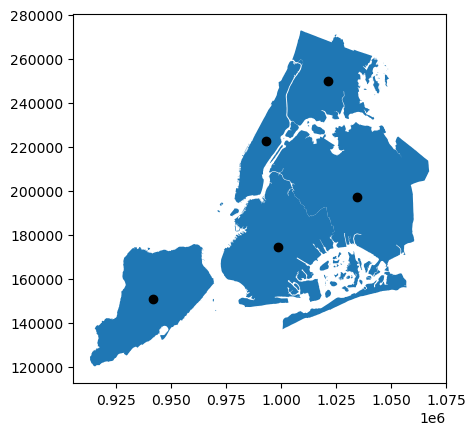

In [38]:
ax = gdf["geometry"].plot()
gdf["centroid"].plot(ax=ax, color="black")

### Downloading and using different GeoJson files

https://data.statistik.gv.at/web/catalog.jsp  
https://github.com/ginseng666/GeoJSON-TopoJSON-Austria

In [39]:
gdf2 = gpd.read_file('../../Data/geo/KDZ_Stadtregionen_GEM_20160101.geojson')
gdf2

,gkz,name,sr_zone,sr_name,is_core,sr_region,geometry
0,10101,Eisenstadt,SR341,Kernzone Eisenstadt,1,SR340,"MULTIPOLYGON (((636886.650 445997.090, 636910...."
1,10301,Breitenbrunn am Neusiedler See,SR012,Aussenzone Wien,0,SR010,"MULTIPOLYGON (((651357.030 458158.250, 651357...."
2,10303,Großhöflein,SR341,Kernzone Eisenstadt,1,SR340,"MULTIPOLYGON (((635646.620 445609.140, 635646...."
3,10305,Klingenbach,SR342,Aussenzone Eisenstadt,0,SR340,"MULTIPOLYGON (((644141.140 433837.300, 644140...."
4,10308,Müllendorf,SR341,Kernzone Eisenstadt,1,SR340,"MULTIPOLYGON (((635196.980 445521.970, 635203...."
...,...,...,...,...,...,...,...
758,80421,Übersaxen,SR082,Aussenzone Feldkirch,0,SR080,"MULTIPOLYGON (((123159.810 380528.300, 123185...."
759,80422,Viktorsberg,SR081,Kernzone Feldkirch,1,SR080,"MULTIPOLYGON (((131359.490 384754.890, 131331...."
760,80423,Weiler,SR081,Kernzone Feldkirch,1,SR080,"MULTIPOLYGON (((122698.440 386159.470, 122731...."
761,80424,Zwischenwasser,SR081,Kernzone Feldkirch,1,SR080,"MULTIPOLYGON (((122263.580 381678.660, 122261...."


In [40]:
gdf2 = gdf2.set_index("name")
gdf2.area

name
Eisenstadt                        4.284435e+07
Breitenbrunn am Neusiedler See    2.572728e+07
Großhöflein                       1.424942e+07
Klingenbach                       4.819706e+06
Müllendorf                        1.278023e+07
                                      ...     
Übersaxen                         5.755935e+06
Viktorsberg                       1.249347e+07
Weiler                            3.080061e+06
Zwischenwasser                    2.260767e+07
Wien                              4.146483e+08
Length: 763, dtype: float64

<Axes: >

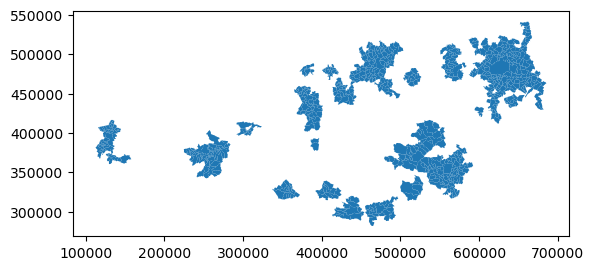

In [41]:
gdf2.plot()


My Maps
#### See also:
[Geocoding](https://geopandas.org/docs/user_guide/geocoding.html)  
[Aggregations](https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html)  
[Spatial Joins](https://geopandas.org/docs/user_guide/mergingdata.html)  
[Gallery](https://geopandas.org/gallery/index.html)  

## Using [Folium](http://python-visualization.github.io/folium/)

In [42]:
!pip install folium

In [43]:
import folium
from folium import Choropleth, Circle, Marker, GeoJson
from folium.plugins import HeatMap, MarkerCluster

In [44]:
m = folium.Map(location=[48.2, 16.3])
m

Saving into an HTML file

In [45]:
m.save("index.html")

In [46]:
m = folium.Map(location=[45.372, -121.6972], zoom_start=12, tiles="Stamen Terrain")

tooltip = "Click me!"

folium.Marker([45.3288, -121.6625], popup="<i>Mt. Hood Meadows</i>", tooltip=tooltip).add_to(m)
folium.Marker([45.3311, -121.7113], popup="<b>Timberline Lodge</b>", tooltip=tooltip).add_to(m)

m

ValueError: Custom tiles must have an attribution.

#### There is built in support for colors and marker icon types from bootstrap.

In [47]:
m = folium.Map(location=[45.372, -121.6972], zoom_start=12, tiles="Stamen Terrain")

folium.Marker(location=[45.3288, -121.6625], popup="Mt. Hood Meadows", icon=folium.Icon(icon="cloud"),).add_to(m)
folium.Marker(location=[45.3311, -121.7113], popup="Timberline Lodge", icon=folium.Icon(color="green"),).add_to(m)
folium.Marker(location=[45.3300, -121.6823], popup="Some Other Location", icon=folium.Icon(color="red", icon="info-sign"),).add_to(m)

m

ValueError: Custom tiles must have an attribution.

#### GeoJSON/TopoJSON Overlays  

Both GeoJSON and TopoJSON layers can be passed to the map as an overlay, and multiple layers can be visualized on the same map:

In [35]:
url = ("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data")

antarctic_ice_edge = f"{url}/antarctic_ice_edge.json"
antarctic_ice_shelf_topo = f"{url}/antarctic_ice_shelf_topo.json"


m = folium.Map(location=[-59.1759, -11.6016], tiles="cartodbpositron", zoom_start=4,)
folium.GeoJson(antarctic_ice_edge, name="geojson").add_to(m)
folium.TopoJson(json.loads(requests.get(antarctic_ice_shelf_topo).text), "objects.antarctic_ice_shelf", name="topojson",).add_to(m)
folium.LayerControl().add_to(m)

m

### Case study 1: Using Nominatim for plotting UFO Data

http://wiki.openstreetmap.org/wiki/Nominatim_usage_policy  
https://github.com/twain47/Nominatim/blob/master/docs/Installation.md

In [36]:
from nominatim import Nominatim

In [37]:
base_url = "http://www.nuforc.org/webreports/"
index_url = "http://www.nuforc.org/webreports/ndxevent.html"

In [38]:
def can_cast_as_dt(dateStr, fmt):
    try:
        datetime.strptime(dateStr, fmt)
        return True
    except ValueError:
        return False

def parse_dt(dateStr):
    # the data in the website comes in two different formats, try both 
    for fmt in ["%m/%d/%y %H:%M", "%m/%d/%y"]:
        try:
            return datetime.strptime(dateStr, fmt)
        except ValueError:
            continue

def get_data_from_url(url):
    print("Processing {}".format(url))
    data = []
    source = BeautifulSoup(urllib.request.urlopen(url), "html5lib")
    for row in source('tr'):
        if not row('td'):
            continue # header row
        row_data = row('td')
        # parse the datetime from the string
        date_time = parse_dt(row_data[0].text)
        city = row_data[1].text
        state = row_data[2].text
        country = row_data[3].text
        shape = row_data[5].text
        duration = row_data[5].text
        data.append((date_time, city, state, country, shape, duration))
    return data

In [39]:
# get the index page
raw_page = requests.get(index_url)
source = BeautifulSoup(raw_page.text,'html5')

# get all the links in the index page
func1 = lambda x: (x.text, base_url + x['href'])
monthly_urls = list(map(func1,source('a')))
# get  the last 12 links that have a text like mm/yyyy
func2 = lambda x: can_cast_as_dt(x[0], "%m/%Y")
last_year_urls = filter(func2, monthly_urls[0:13]) 
# extract the data from each monthly page and flatten the lists of tuples
last_year_ufos = list(chain(*map(lambda x: get_data_from_url(x[1]), last_year_urls)))
# initialize a pandas DataFrame with the list of tuples

Processing http://www.nuforc.org/webreports/ndxe202212.html
Processing http://www.nuforc.org/webreports/ndxe202211.html
Processing http://www.nuforc.org/webreports/ndxe202210.html
Processing http://www.nuforc.org/webreports/ndxe202209.html
Processing http://www.nuforc.org/webreports/ndxe202208.html
Processing http://www.nuforc.org/webreports/ndxe202207.html
Processing http://www.nuforc.org/webreports/ndxe202206.html
Processing http://www.nuforc.org/webreports/ndxe202205.html
Processing http://www.nuforc.org/webreports/ndxe202204.html
Processing http://www.nuforc.org/webreports/ndxe202203.html
Processing http://www.nuforc.org/webreports/ndxe202202.html
Processing http://www.nuforc.org/webreports/ndxe202201.html


In [40]:
ufos_df = pd.DataFrame(last_year_ufos, columns=["start","city","state","country","shape", "duration"])

In [41]:
ufos_df.head()

,start,city,state,country,shape,duration
0,2022-12-22 10:50:00,Ahmedabad,,,15 seconds,15 seconds
1,2022-12-22 09:29:00,Newark,DE,USA,30 secomds,30 secomds
2,2022-12-22 00:00:00,Johannesburg,Gauteng,South Africa,15 min,15 min
3,2022-12-21 21:33:00,Columbus,OH,USA,1-2 minutes,1-2 minutes
4,2022-12-21 17:40:00,Didcot,Oxfordshire,United Kingdom,2 minutes,2 minutes


In [42]:
ufos_df.replace(to_replace='', value=np.nan, inplace=True, limit=None, regex=False, method='pad')
ufos_df = ufos_df.dropna() 

In [43]:
ufos_df.head()

,start,city,state,country,shape,duration
0,2022-12-22 10:50:00,Ahmedabad,,,15 seconds,15 seconds
1,2022-12-22 09:29:00,Newark,DE,USA,30 secomds,30 secomds
2,2022-12-22 00:00:00,Johannesburg,Gauteng,South Africa,15 min,15 min
3,2022-12-21 21:33:00,Columbus,OH,USA,1-2 minutes,1-2 minutes
4,2022-12-21 17:40:00,Didcot,Oxfordshire,United Kingdom,2 minutes,2 minutes


#### Engineering time

In [44]:
# function that infers the duration from the text 
def infer_duration_in_seconds(text):
    # try different regexps to extract the total seconds
    text = text.replace('<','')
    text = text.replace('>','')
    text = text.replace('?','')
    text = text.replace('+','')
    text = text.replace('~','')
    metric_text = ["second","s","Second","segundo","minute","m","min","Minute","hour","h","Hour",'Currently']
    metric_seconds = [1,1,1,1,60,60,60,3600,3600,3600,10]
    for metric,mult in zip(metric_text, metric_seconds):
        regex = "\s*(\d+)\+?\s*{}s?".format(metric)
        res = re.findall(regex,text)
        if len(res)>0:
            return int(float(res[0]) * mult)
    return 0

In [45]:
# extract the duration in seconds
ufos_df["duration_secs"] = ufos_df["duration"].apply(infer_duration_in_seconds)

# now we can infer the end time of the UFO sighting as well
# which will be useful for the animation later
ufos_df["end"] = ufos_df.apply(lambda x:x["start"] + timedelta(seconds=x["duration_secs"]),axis=1)
ufos_df = ufos_df.dropna()

In [46]:
ufos_df.head()

,start,city,state,country,shape,duration,duration_secs,end
0,2022-12-22 10:50:00,Ahmedabad,,,15 seconds,15 seconds,15,2022-12-22 10:50:15
1,2022-12-22 09:29:00,Newark,DE,USA,30 secomds,30 secomds,30,2022-12-22 09:29:30
2,2022-12-22 00:00:00,Johannesburg,Gauteng,South Africa,15 min,15 min,900,2022-12-22 00:15:00
3,2022-12-21 21:33:00,Columbus,OH,USA,1-2 minutes,1-2 minutes,120,2022-12-21 21:35:00
4,2022-12-21 17:40:00,Didcot,Oxfordshire,United Kingdom,2 minutes,2 minutes,120,2022-12-21 17:42:00


#### Finding Locations

In [47]:
geolocator = Nominatim()
geolocator.query('Newport News')
#geolocator.query("Houston, TX")

[{'place_id': 241604,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'osm_type': 'node',
  'osm_id': 158616376,
  'boundingbox': ['36.8175016', '37.1375016', '-76.58977', '-76.26977'],
  'lat': '36.9775016',
  'lon': '-76.42977',
  'display_name': 'Newport News, Virginia, 23607, United States',
  'class': 'place',
  'type': 'city',
  'importance': 0.686660556787456,
  'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_place_city.p.20.png'},
 {'place_id': 308246247,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'osm_type': 'relation',
  'osm_id': 3864704,
  'boundingbox': ['36.930691', '37.2206658', '-76.646093', '-76.36161'],
  'lat': '37.0914429',
  'lon': '-76.5213892',
  'display_name': 'Newport News, Virginia, United States',
  'class': 'boundary',
  'type': 'administrative',
  'importance': 0.686660556787456,
  'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_adminis

In [48]:
#Be careful with too many queries made to the server in a short period of time

ufos_df["lat"] = 0
ufos_df["lon"] = 0
for i in range(len(ufos_df[0:10])):
    try:
        resp_json = geolocator.query(ufos_df['city'][i])
        ufos_df.loc[i, "lat"] = resp_json[0]['lat']
        ufos_df.loc[i, "lon"] = resp_json[0]['lon']
    except:
        ufos_df.loc[i, "lat"] = 0
        ufos_df.loc[i, "lat"] = 0
    time.sleep(1.5)

In [49]:
ufos_df.to_pickle(os.path.join('../../Data/','ufos_df.pkl'))
ufos_df = pd.read_pickle(os.path.join('../../Data','ufos_df.pkl'))
ufos_df.head(10)

,start,city,state,country,shape,duration,duration_secs,end,lat,lon
0,2022-12-22 10:50:00,Ahmedabad,,,15 seconds,15 seconds,15,2022-12-22 10:50:15,23.0216238,72.5797068
1,2022-12-22 09:29:00,Newark,DE,USA,30 secomds,30 secomds,30,2022-12-22 09:29:30,40.735657,-74.1723667
2,2022-12-22 00:00:00,Johannesburg,Gauteng,South Africa,15 min,15 min,900,2022-12-22 00:15:00,-26.205,28.049722
3,2022-12-21 21:33:00,Columbus,OH,USA,1-2 minutes,1-2 minutes,120,2022-12-21 21:35:00,39.9622601,-83.0007065
4,2022-12-21 17:40:00,Didcot,Oxfordshire,United Kingdom,2 minutes,2 minutes,120,2022-12-21 17:42:00,51.6121773,-1.2439778415871414
5,2022-12-21 07:55:00,Essex,ON,Canada,20 minutes,20 minutes,1200,2022-12-21 08:15:00,51.77046785,0.46466977412300386
6,2022-12-21 04:11:00,Franklin,ME,USA,2 hours,2 hours,7200,2022-12-21 06:11:00,33.2002659,-95.2231752
7,2022-12-20 23:30:00,East Greenwich,RI,USA,3 seconds maybe even less,3 seconds maybe even less,3,2022-12-20 23:30:03,41.6603788,-71.4558911
8,2022-12-20 21:58:00,Mentor Headlands,OH,USA,A few minutes,A few minutes,0,2022-12-20 21:58:00,41.75682935,-81.28825009371027
9,2022-12-20 02:30:00,Washington DC,WA,USA,1-2 minutes,1-2 minutes,120,2022-12-20 02:32:00,38.8950368,-77.0365427


In [50]:
# Note: dropna will drop any columns with None values, which is desirable
ufos_df[["start","end","lon","lat","shape"]].dropna().to_csv(os.path.join('../../Data/',
                                                                          'ufo_data.csv'),
                                                             index=False, encoding="utf-8")

In [51]:
gdf = gpd.GeoDataFrame(ufos_df, geometry=gpd.points_from_xy(ufos_df.lon, ufos_df.lat))
gdf.head()

,start,city,state,country,shape,duration,duration_secs,end,lat,lon,geometry
0,2022-12-22 10:50:00,Ahmedabad,,,15 seconds,15 seconds,15,2022-12-22 10:50:15,23.0216238,72.5797068,POINT (72.57971 23.02162)
1,2022-12-22 09:29:00,Newark,DE,USA,30 secomds,30 secomds,30,2022-12-22 09:29:30,40.735657,-74.1723667,POINT (-74.17237 40.73566)
2,2022-12-22 00:00:00,Johannesburg,Gauteng,South Africa,15 min,15 min,900,2022-12-22 00:15:00,-26.205,28.049722,POINT (28.04972 -26.20500)
3,2022-12-21 21:33:00,Columbus,OH,USA,1-2 minutes,1-2 minutes,120,2022-12-21 21:35:00,39.9622601,-83.0007065,POINT (-83.00071 39.96226)
4,2022-12-21 17:40:00,Didcot,Oxfordshire,United Kingdom,2 minutes,2 minutes,120,2022-12-21 17:42:00,51.6121773,-1.2439778415871414,POINT (-1.24398 51.61218)


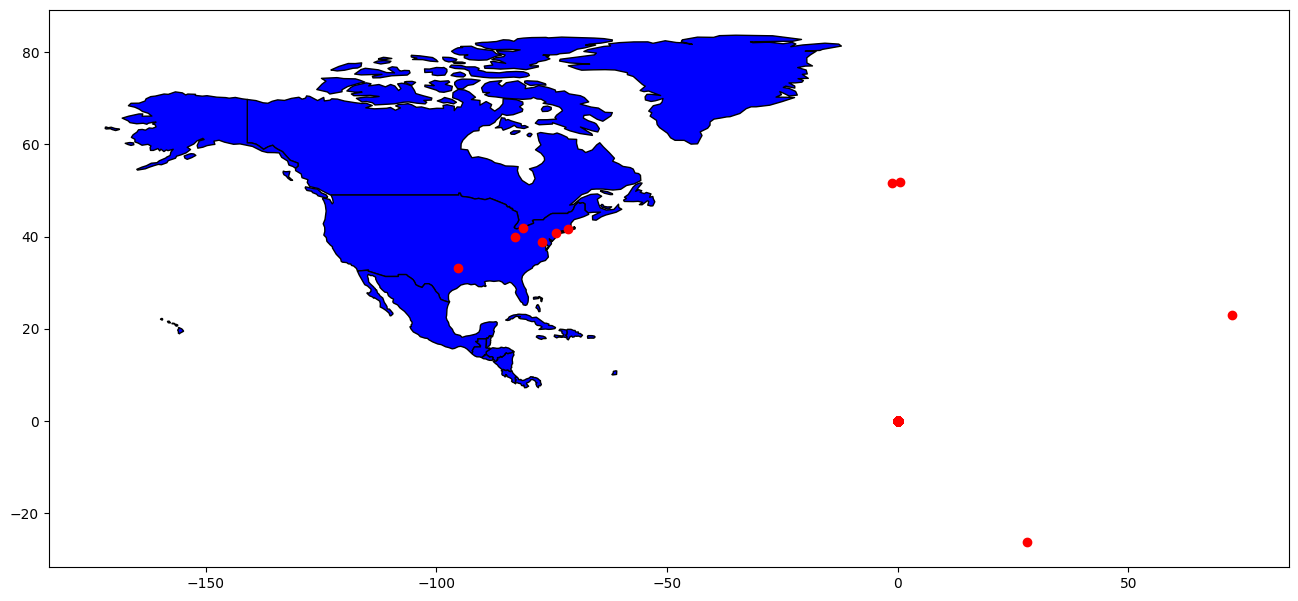

In [52]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# We restrict to North America.
ax = world[world.continent == 'North America'].plot(color='blue', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')
plt.show()

### Case study 2: Spatial Analysis with Twitter

[You will need to generate keys for accessing the Twitter API](https://developer.twitter.com/en/docs/authentication/oauth-1-0a/api-key-and-secret)

In [53]:
import twitter

In [54]:
with open('./twitter_tokens.txt', 'r') as twitter_tokens:
    tokens = twitter_tokens.read().split(',')
consumer_key = tokens[0].strip()
consumer_secret = tokens[1].strip()
access_token = tokens[2].strip()
access_token_secret = tokens[3].strip()

FileNotFoundError: [Errno 2] No such file or directory: './twitter_tokens.txt'

In [ ]:
api = twitter.Api(consumer_key, consumer_secret, access_token, access_token_secret, sleep_on_rate_limit=True)

In [ ]:
msgpublicas = api.GetStreamSample()
geo_points = 0
lats, lons = [], []
users = []
while geo_points < 3:
    tweet = next(msgpublicas)
    if 'coordinates' in tweet.keys() and tweet['coordinates'] != None:
        print(tweet['text'])
        coords = tweet['coordinates']['coordinates']
        user = tweet['user']['id']
        print(u'User {} in coordinates {}'.format(user, [coords[1],coords[0]]))
        lons.append(float(coords[0]))
        lats.append(float(coords[1]))
        users.append(user)
        geo_points +=1

In [ ]:
df_twitter = pd.DataFrame({'User':users, 'lat':lats, 'long':lons})
df_twitter.to_pickle(os.path.join('../../Data/','df_twitter.pkl'))
df_twitter = pd.read_pickle(os.path.join('../../Data','df_twitter.pkl'))
df_twitter.head()

In [ ]:
gdf_twitter = gpd.GeoDataFrame(df_twitter, geometry=gpd.points_from_xy(df_twitter.long, df_twitter.lat))
gdf_twitter.head()

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
gdf_twitter.plot(ax=ax, color='green')
plt.show()